In [4]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np
import scipy as sp
from scipy.ndimage.filters import gaussian_filter1d
import sqlite3 as sql
import os
import pandas as pd
from datetime import datetime
from glob import glob
os.sys.path.append('../')
from utilities import *
from astropy.convolution import convolve, Gaussian1DKernel

%load_ext autoreload
%autoreload 2

%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [11]:
# find sessions from single mouse on TwoTower_noTimeout with datestring earlier than or equal to first timeout day
# num rewards greater than 
try:
    df = load_session_db()
except:
    df = load_session_db(dir="/Volumes/GoogleDrive/My Drive/VR_Data/TwoTower")
    
mouse = '4139190.1'
# mouse filter
df = df[df['MouseName'].str.match(mouse)]
df = df[df['RewardCount']>10]
df = df[df['Imaging']==1]

df_noTO = df[df['Track']=='TwoTower_noTimeout']
df_TO = df[df['Track']=='TwoTower_Timeout']
df_TO = df_TO.sort_values('DateTime')
df_noTO[df_noTO['DateTime'] < df_TO['DateTime'].iloc[0]]



df_noTO = df_noTO.sort_values(by=['DateTime','SessionNumber'])
df_noTO

,MouseName,DateFolder,SessionNumber,Track,RewardCount,Imaging,DateTime,data file,scanfile,scanmat
213,4139190.1,15_06_2018,1,TwoTower_noTimeout,56,1,2018-06-15,/Volumes/GoogleDrive/My Drive/VR_Data/TwoTower...,None,None
212,4139190.1,15_06_2018,3,TwoTower_noTimeout,48,1,2018-06-15,/Volumes/GoogleDrive/My Drive/VR_Data/TwoTower...,None,None
151,4139190.1,16_06_2018,2,TwoTower_noTimeout,59,1,2018-06-16,/Volumes/GoogleDrive/My Drive/VR_Data/TwoTower...,None,None


In [12]:
# concatenate desired sessions
#data_noTO = behavior_dataframe([df_noTO['data file'].iloc[i] for i in range(df_noTO.shape[0])],scanmats=[df_noTO['scanmat'].iloc[i] for i in range(df_noTO.shape[0])],concat=True)
data_noTO = behavior_dataframe(df_noTO['data file'].iloc[0],scanmats=df_noTO['scanmat'].iloc[0])
#data_noTO = behavior_dataframe(df_noTO['data file'].iloc[0])

/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:2754: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


In [13]:
# make speed vs location plots
# correct for frame times
trial_mat, bin_edges, bin_centers = make_pos_bin_trial_matrices(data_noTO[['speed','morph','lick rate','reward','lick']]._values,
                                              data_noTO['pos']._values,
                                              data_noTO['tstart']._values,
                                              data_noTO['teleport']._values,bin_size=5)
speed_mat, bin_edges, bin_centers = make_pos_bin_trial_matrices(np.diff(np.insert(data_noTO['pos']._values,0,-5,axis=0)),
                                              data_noTO['pos']._values,
                                              data_noTO['tstart']._values,
                                              data_noTO['teleport']._values,bin_size=5)

trial_mat[np.isnan(trial_mat)]=0
morph_vec,count = sp.stats.mode(trial_mat[:,:,1],axis=1,nan_policy='omit')
morph_vec = np.squeeze(morph_vec)

#print(trial_mat[:,:-1])
hits = np.squeeze(np.nanmax(trial_mat[:,:,-1],axis=1))
hits[hits>0]=1


(0, 100)

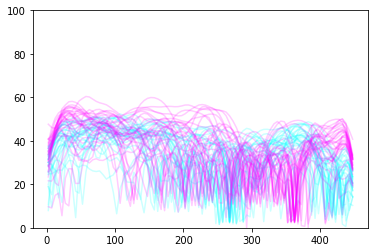

In [14]:
f, ax = plt.subplots()
speed_dict = trial_type_dict(trial_mat[:,:,0],morph_vec)

for i, m in enumerate(np.unique(morph_vec)):
    for j in range(speed_dict[m].shape[0]):
        tmp = ax.plot(bin_centers,speed_dict[m][j,:].T,color=plt.cm.cool(np.float(m)),alpha=.2)
        #print(speed_dict[m][j,:])
ax.set_ylim([0, 100])

../utilities.py:571: RuntimeWarning: invalid value encountered in true_divide
  rzone_lick_ratio[m] = np.divide(zone0_lick_rate,zone0_lick_rate+zone1_lick_rate)


[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.]


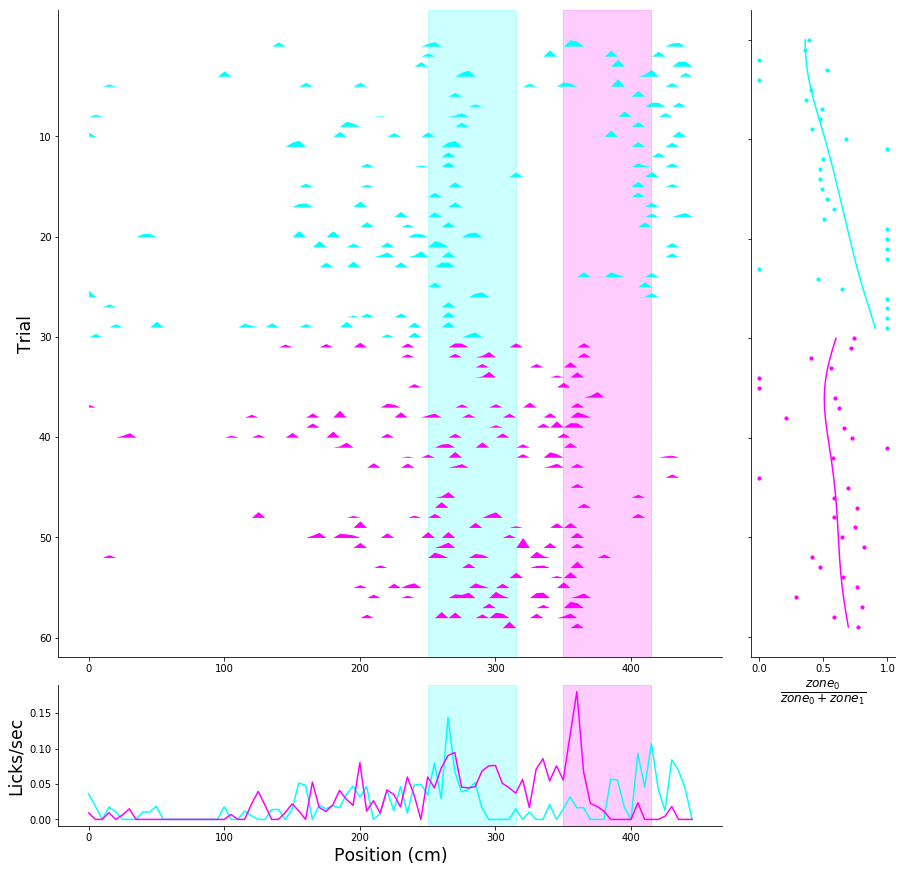

In [15]:
lick_dict = trial_type_dict(trial_mat[:,:,4],morph_vec)
lick_mat = np.squeeze(trial_mat[:,:,2])
lick_mat_norm = lick_dict['all']/np.amax(lick_dict['all'])
lick_norm_dict = trial_type_dict(lick_mat_norm,morph_vec)
fig,axes = lick_plot(lick_norm_dict,bin_edges,smooth=False)
print(morph_vec)

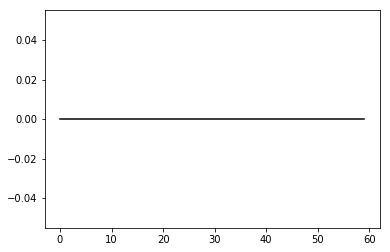

In [16]:
# omission rate v trials
f, ax = plt.subplots()
ax.plot(np.arange(hits.shape[0]),np.cumsum(1-hits),color='black')


In [17]:
######### find timeout sessions
df_TO = df_TO.sort_values(by=['DateTime','SessionNumber'])
df_TO


,MouseName,DateFolder,SessionNumber,Track,RewardCount,Imaging,DateTime,data file,scanfile,scanmat
150,4139190.1,16_06_2018,2,TwoTower_Timeout,19,1,2018-06-16,/Volumes/GoogleDrive/My Drive/VR_Data/TwoTower...,None,None
210,4139190.1,19_06_2018,2,TwoTower_Timeout,75,1,2018-06-19,/Volumes/GoogleDrive/My Drive/VR_Data/TwoTower...,None,None
177,4139190.1,21_06_2018,2,TwoTower_Timeout,20,1,2018-06-21,/Volumes/GoogleDrive/My Drive/VR_Data/TwoTower...,None,None
175,4139190.1,21_06_2018,3,TwoTower_Timeout,92,1,2018-06-21,/Volumes/GoogleDrive/My Drive/VR_Data/TwoTower...,None,None
169,4139190.1,24_06_2018,2,TwoTower_Timeout,104,1,2018-06-24,/Volumes/GoogleDrive/My Drive/VR_Data/TwoTower...,None,None
173,4139190.1,25_06_2018,2,TwoTower_Timeout,62,1,2018-06-25,/Volumes/GoogleDrive/My Drive/VR_Data/TwoTower...,None,None
205,4139190.1,27_06_2018,2,TwoTower_Timeout,81,1,2018-06-27,/Volumes/GoogleDrive/My Drive/VR_Data/TwoTower...,None,None
164,4139190.1,28_06_2018,2,TwoTower_Timeout,17,1,2018-06-28,/Volumes/GoogleDrive/My Drive/VR_Data/TwoTower...,None,None
160,4139190.1,28_06_2018,8,TwoTower_Timeout,22,1,2018-06-28,/Volumes/GoogleDrive/My Drive/VR_Data/TwoTower...,None,None
165,4139190.1,28_06_2018,9,TwoTower_Timeout,18,1,2018-06-28,/Volumes/GoogleDrive/My Drive/VR_Data/TwoTower...,None,None


In [18]:
#data_TO = behavior_dataframe([df_TO['data file'].iloc[i] for i in range(df_TO.shape[0])])
data_TO = behavior_dataframe(df_TO['data file'].iloc[4],scanmats=df_TO['scanmat'].iloc[4])
#data_TO = behavior_dataframe(df_TO['data file'].iloc[4])



OperationalError: disk I/O error

In [10]:
# make speed vs location plots
# correct for frame times
trial_mat, bin_edges, bin_centers = make_pos_bin_trial_matrices(data_TO[['speed','morph','lick rate','reward','lick']]._values,
                                              data_TO['pos']._values,
                                              data_TO['tstart']._values,
                                              data_TO['teleport']._values,bin_size=5)
# speed_mat, bin_edges, bin_centers = make_pos_bin_trial_matrices(np.diff(np.insert(data_TO['pos']._values,0,-5,axis=0)),
#                                               data_TO['pos']._values,
#                                               data_TO['tstart']._values,
#                                               data_TO['teleport']._values,bin_size=5)

#trial_mat[np.isnan(trial_mat)]=0
morph_vec,count = sp.stats.mode(trial_mat[:,:,1],axis=1)
morph_vec = np.squeeze(morph_vec)

#print(trial_mat[:,:-1])
hits = np.squeeze(np.nanmax(trial_mat[:,:,-1],axis=1))
hits[hits>0]=1

#correct
rewarded = np.squeeze(np.nanmax(trial_mat[:,:,3],axis=1))
print(rewarded)
rewarded[rewarded>0]=1
#for (r,m) in zip(rewarded.tolist(),morph_vec.tolist()):
#    print(r,m)
#print(np.where((rewarded==0) & (morph_vec>.5))[0])


# reward_pos = np.array(bin_edges)[np.squeeze(np.argmax(trial_mat[:,:,3],axis=1))]
# print()
print("percent rewarded: %f" % (rewarded.sum()/rewarded.shape[0]))


# print()

[0.02857143 0.0625     0.05263158 0.02564103 0.03030303 0.02380952
 0.02040816 0.         0.02702703 0.01785714 0.1        0.02777778
 0.02857143 0.03225806 0.02631579 0.01923077 0.02941176 0.
 0.02564103 0.02702703 0.2        0.02777778 0.02857143 0.02631579
 0.         0.02380952 0.02325581 0.02272727 0.03125    0.02777778
 0.03448276 0.03846154 0.06666667 0.         0.01923077 0.
 0.02083333 0.25       0.02222222 0.         0.07142857 0.02857143
 0.125      0.         0.05882353 0.01612903 0.02777778 0.02564103
 0.02702703 0.05555556 0.02       0.02941176 0.25       0.04761905
 0.01470588 0.07692308 0.02857143 0.2        0.11111111 0.125
 0.025      0.07692308 0.2        0.1        0.03846154 0.01724138
 0.02380952 0.02941176 0.03703704 0.02857143 0.         0.02325581
 0.07692308 0.         0.08333333 0.2        0.2        0.16666667
 0.07692308 0.07142857 0.01923077 0.03846154 0.09090909 0.09090909
 0.02439024 0.03571429 0.08333333 0.1        0.02777778 0.08333333
 0.09090909 0.00

(90,)
(114, 90)


(0, 100)

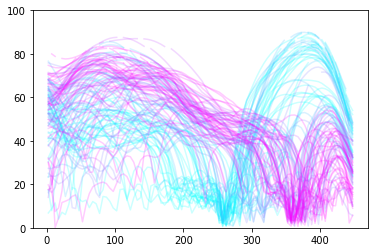

In [11]:
# speed vs location 
#trial_mat[0,0:5,0 ] = 0
f, ax = plt.subplots()
speed_dict = trial_type_dict(trial_mat[:,:,0],morph_vec)
print(bin_centers.shape)
print(speed_dict['all'].shape)
for i, m in enumerate(np.unique(morph_vec)):
    for j in range(speed_dict[m].shape[0]):
        tmp = ax.plot(bin_centers,speed_dict[m][j,:].T,color=plt.cm.cool(np.float(m)),alpha=.2)
ax.set_ylim([0, 100])
#print(speed_dict[1])

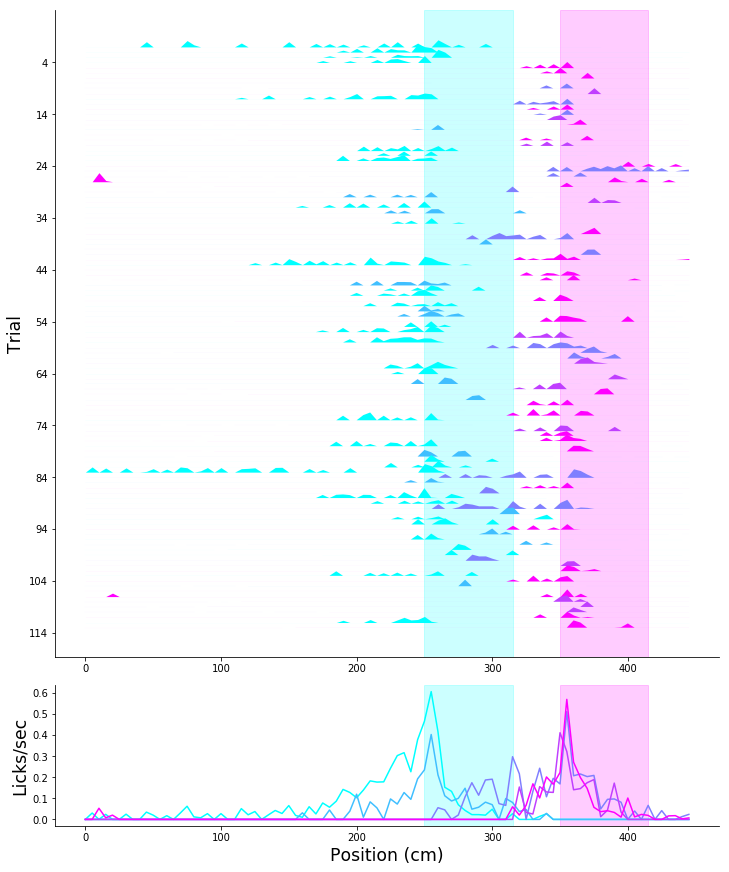

In [15]:
# lick rate
lick_dict = trial_type_dict(trial_mat[:,:,-1],morph_vec)

#print(lick_dict['labels']==morph_vec.tolist())
#lick_mat = np.squeeze(trial_mat[:,:,-1])
#lick_mat_norm = lick_dict['all']/np.amax(lick_dict['all'])
# lick_norm_dict = trial_type_dict(lick_mat_norm,morph_vec)
fig,axes = lick_plot(lick_dict,bin_edges,smooth=False,ratio=False)

NameError: name 'correct' is not defined

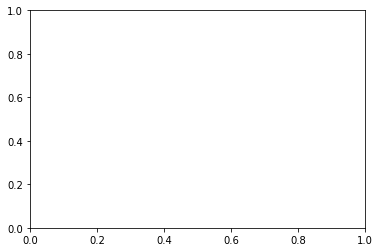

In [23]:

# cumulative errors (including vs excluding omissions)
f,ax = plt.subplots()
ax.plot(np.cumsum(1-correct))
ax.plot(np.arange(correct.shape[0]),.5*np.arange(correct.shape[0]))
ax.set_ylim([0,correct.shape[0]])
ax.legend(('chance accuracy','actual error rate'))
ax.set_ylabel('Cumulative Errors')
ax.set_xlabel('Trial Number')


In [137]:
# if reward == 0 and teleport position > 430:
        # omission
        
# find first tower lick percentage ()
    # if reward == 1:
        # if morph <.5 :
            # count 1
        # if morph > .5:
            # count 0
        # if morph == .5:
            # sum licks in reward zone 

In [ ]:
# percent correct vs session

# percent trials  lick at first tower vs morph

In [ ]:
# percent correct vs wall jitter
    # for each session
    
    # combined

In [ ]:
# percent correct vs tower jitter

In [ ]:
# percent correct vs background jitter